/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


null values 0


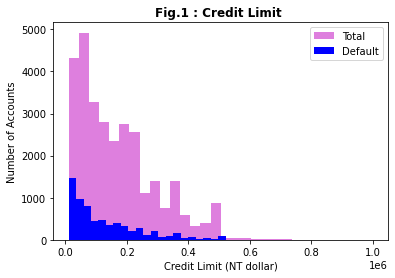

checking for ouliers in the data set


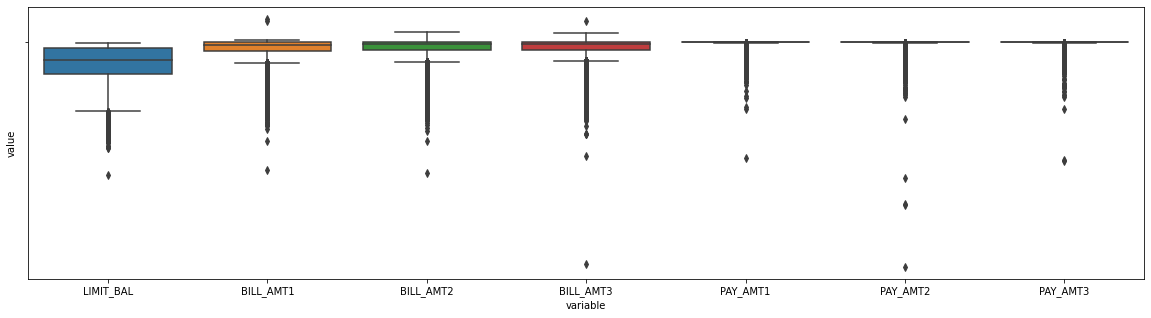

In [5]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot

# load the csv file 
cols = list(pd.read_csv("UCI_Credit_Card.csv", nrows =1))
# remove the ID column 
cols.pop(0)
df = pd.read_csv('UCI_Credit_Card.csv' , usecols = cols)
print('null values', df.isnull().values.sum())

# from this plot we can see that there is a clear class imbalance
bins = 30
plt.hist(df.LIMIT_BAL, bins = bins, color='m',label = 'Total',alpha=0.5)
plt.hist(df.LIMIT_BAL[df['default.payment.next.month'] == 1], bins = bins, color='b',label = 'Default')

plt.xlabel('Credit Limit (NT dollar)');plt.ylabel('Number of Accounts')
plt.title('Fig.1 : Credit Limit ',fontweight="bold", size=12)
plt.legend();plt.show()

# check for outliers
print('checking for ouliers in the data set')
plt.figure(figsize=(20,5))
sns.boxplot(x=df['LIMIT_BAL'])
df_box_plt = df[['LIMIT_BAL','BILL_AMT1','BILL_AMT2','BILL_AMT3','PAY_AMT1','PAY_AMT2','PAY_AMT3']]
sns.boxplot(x="variable", y="value", data=pd.melt(df_box_plt))






       LIMIT_BAL  SEX  EDUCATION  ...  PAY_AMT4  PAY_AMT5  PAY_AMT6
0       0.969135    2          2  ...  0.000000  0.000000  0.000000
1       0.998005    2          2  ...  0.008317  0.000000  0.016633
2       0.898265    2          2  ...  0.009981  0.009981  0.049904
3       0.456620    2          2  ...  0.010046  0.009763  0.009132
4       0.615783    1          2  ...  0.110841  0.008485  0.008362
...          ...  ...        ...  ...       ...       ...       ...
29995   0.527102    1          3  ...  0.007300  0.011980  0.002396
29996   0.995086    1          3  ...  0.000856  0.000000  0.000000
29997   0.579389    1          2  ...  0.081114  0.038626  0.059870
29998   0.434543    1          3  ...  0.010462  0.287689  0.009799
29999   0.450856    1          2  ...  0.009017  0.009017  0.009017

[30000 rows x 23 columns]


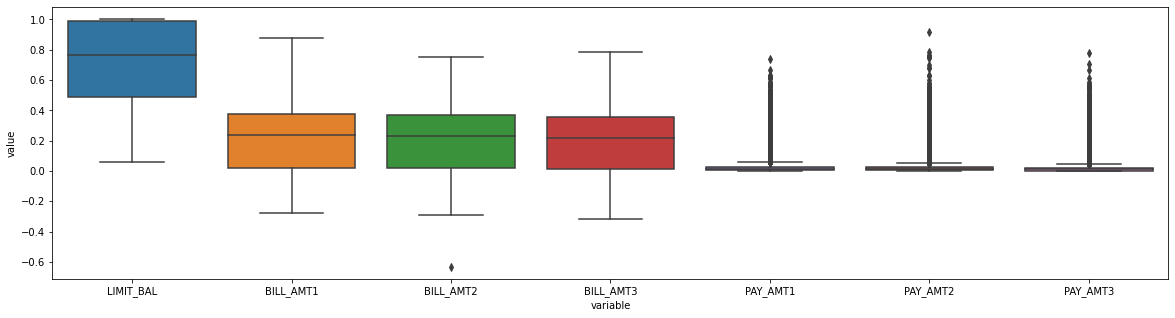

In [6]:
feature_set = cols
feature_set.pop()

# Separating out the features
x = df.loc[:, feature_set].values
# Separating out the target
y = df.loc[:,['default.payment.next.month']].values

x= preprocessing.normalize(x)
# convert numpy normalised array back to data frame
df_norm = pd.DataFrame(data=x,columns=feature_set)

plt.figure(figsize=(20,5))
df_box_plt_norm = df_norm[['LIMIT_BAL','BILL_AMT1','BILL_AMT2','BILL_AMT3','PAY_AMT1','PAY_AMT2','PAY_AMT3']]
sns.boxplot(x="variable", y="value", data=pd.melt(df_box_plt_norm))
# replace columns sex , education , columns
df_norm[['SEX','EDUCATION','MARRIAGE','AGE']]=df[['SEX','EDUCATION','MARRIAGE','AGE']]
print(df_norm)

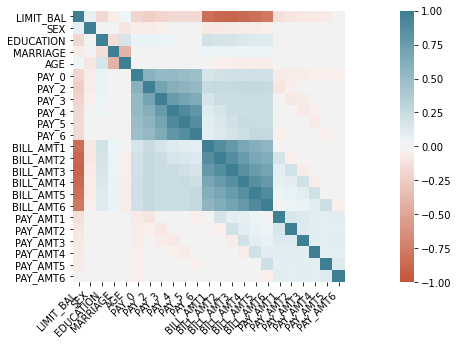

In [7]:
#plot correlation heatmap
corr = df_norm.corr()
plt.figure(figsize=(20,5))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [8]:
# we can see there are some columns that are highly correlated , so we can apply pca to reduce the number of columns
from sklearn.decomposition import PCA
import numpy as np
pca = PCA()

x_pca = pca.fit_transform(x)
explained_variance = pca.explained_variance_ratio_
np.set_printoptions(suppress=True)
print(explained_variance)
# keeping first four principal components as they explain 90 percent of data variance
pca = PCA(n_components=4)
x_pca = pca.fit_transform(x)
x_df = pd.DataFrame(data = x_pca
             , columns = ['principal component 1' ,'principal component 2','principal component 3', 'principal component 4'])

print(x_df.head())

[0.77173919 0.08218308 0.02976367 0.02268605 0.01884993 0.01659673
 0.01489799 0.01215878 0.01124636 0.00687181 0.00536398 0.00422139
 0.0034205  0.00000054 0.00000001 0.         0.         0.
 0.         0.         0.         0.         0.        ]
   principal component 1  ...  principal component 4
0              -0.385461  ...              -0.032250
1              -0.492746  ...              -0.019966
2              -0.137594  ...              -0.072651
3               0.490499  ...              -0.004051
4               0.127966  ...               0.170243

[5 rows x 4 columns]


In [9]:
from sklearn.utils import resample
# oversampling to overcome class imbalance
y_df = pd.DataFrame(data = y, columns = ['default.payment.next.month'])


#combine them back for resampling
resampled_data = pd.concat([x_df, y_df], axis=1)

# separate minority and majority classes
defaulter = resampled_data[resampled_data['default.payment.next.month']==1]
non_defaulter = resampled_data[resampled_data['default.payment.next.month']==0]

# upsample minority class
defaulter_upsampled = resample(defaulter,replace=True,n_samples=len(non_defaulter), random_state=40) 
# combine the datasets
upsampled_df = pd.concat([non_defaulter, defaulter_upsampled])

# check new class counts
upsampled_df['default.payment.next.month'].value_counts()


# End of preprocessing , now we train our prediction models in the next part






1    23364
0    23364
Name: default.payment.next.month, dtype: int64

In [0]:
#modelling using the upsampled dataframe
from sklearn.model_selection import train_test_split

X = upsampled_df.drop(['default.payment.next.month'],axis=1)
y = upsampled_df['default.payment.next.month']

#split data into test and training sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=40)


Confusion Matrix:
       0     1
0  4347  1447
1   307  5581


Accuracy Score on the test data: 0.849854476973121
Accuracy Score on the train data: 0.9880728185812931


Classification report:
               precision    recall  f1-score   support

           0       0.93      0.75      0.83      5794
           1       0.79      0.95      0.86      5888

    accuracy                           0.85     11682
   macro avg       0.86      0.85      0.85     11682
weighted avg       0.86      0.85      0.85     11682

Area Under ROC Curve : 0.8524254616845013


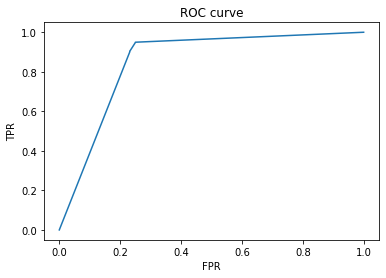

In [0]:
# decision trees
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score,roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


model = DecisionTreeClassifier(random_state=0)
dtree = model.fit(X_train, y_train)

#model evaluation
labels = np.unique(y_test)
cm = confusion_matrix(y_test,dtree.predict(X_test) , labels=labels)
print('Confusion Matrix:\n', pd.DataFrame(cm, index=labels, columns=labels))
print('\n')
print('Accuracy Score on the test data:', accuracy_score(y_true=y_test, y_pred=dtree.predict(X_test)))
print('Accuracy Score on the train data:', accuracy_score(y_true=y_train, y_pred=dtree.predict(X_train)))
print('\n')
print('Classification report:\n',classification_report(y_test,dtree.predict(X_test)))

## roc curve
predictions = dtree.predict_proba(X_test)
print("Area Under ROC Curve :" , roc_auc_score(y_test, predictions[:,1]))
fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()



Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

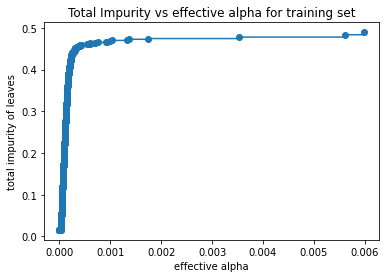

In [0]:
## CCalpha for pruning
path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax2 = plt.subplots()
ax2.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax2.set_xlabel("effective alpha")
ax2.set_ylabel("total impurity of leaves")
ax2.set_title("Total Impurity vs effective alpha for training set")


Confusion Matrix:
       0     1
0  3663  2131
1  2986  2902


Accuracy Score on the test data: 0.5619756890943332
Accuracy Score on the train data: 0.5717628260001142


Classification report:
               precision    recall  f1-score   support

           0       0.55      0.63      0.59      5794
           1       0.58      0.49      0.53      5888

    accuracy                           0.56     11682
   macro avg       0.56      0.56      0.56     11682
weighted avg       0.56      0.56      0.56     11682

Area Under ROC Curve : 0.5980272004115953


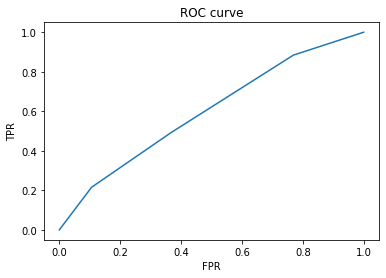

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Decision Tree: 0.834702 (0.008150)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Decision Tree: 0.570993 (0.006448)


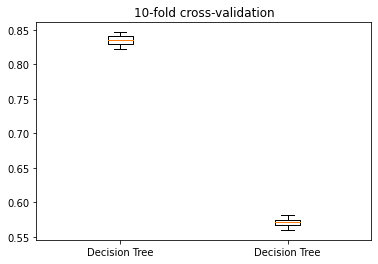

In [0]:
# finding best ccalpha value for decision tree prunning
# as the data set was too big to find the best ccalpha value , we selected the value by trial and error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score,roc_curve, roc_auc_score


model = DecisionTreeClassifier(random_state=0 , ccp_alpha=0.005)
dtree = model.fit(X_train, y_train)

#model evaluation
labels = np.unique(y_test)
cm = confusion_matrix(y_test,dtree.predict(X_test), labels=labels)
print('Confusion Matrix:\n', pd.DataFrame(cm, index=labels, columns=labels))
print('\n')
print('Accuracy Score on the test data:', accuracy_score(y_true=y_test, y_pred=dtree.predict(X_test)))
print('Accuracy Score on the train data:', accuracy_score(y_true=y_train, y_pred=dtree.predict(X_train)))
print('\n')
print('Classification report:\n',classification_report(y_test,dtree.predict(X_test)))

## roc curve
predictions = dtree.predict_proba(X_test)
print("Area Under ROC Curve :" , roc_auc_score(y_test, predictions[:,1]))
fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

# k cross validation
models = []
models.append(('Decision Tree', DecisionTreeClassifier(random_state=0)))
models.append(('Decision Tree', DecisionTreeClassifier(random_state=0 , ccp_alpha=0.005)))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('10-fold cross-validation')
pyplot.show()



**# the following code block may take a lot of time thats why its commented , k-cross result is included in report**

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Confusion Matrix:
       0     1
0  3332  2462
1  2033  3855


Accuracy Score on the test data: 0.6152199965759287
Accuracy Score on the train data: 0.6164469554300063


Classification report:
               precision    recall  f1-score   support

           0       0.62      0.58      0.60      5794
           1       0.61      0.65      0.63      5888

    accuracy                           0.62     11682
   macro avg       0.62      0.61      0.61     11682
weighted avg       0.62      0.62      0.61     11682

Area Under ROC Curve : 0.6529290484862526


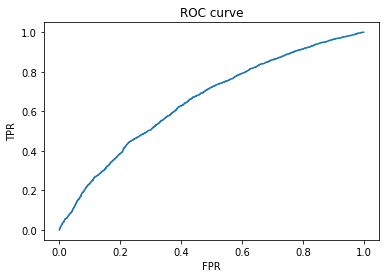

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/module

MLP: 0.604919 (0.005280)


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

MLP: 0.609085 (0.004683)


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

MLP: 0.607402 (0.006048)


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

MLP: 0.608486 (0.006219)


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


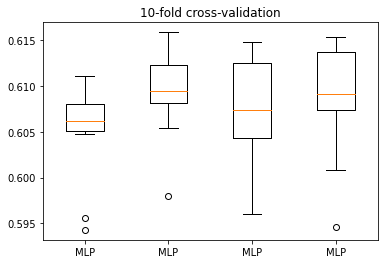

In [0]:
## Neural networks
from sklearn.neural_network import MLPClassifier
model_mlp = MLPClassifier(random_state=0, activation='tanh', hidden_layer_sizes=(5,), solver='lbfgs', max_iter=1000)
MLP = model_mlp.fit(X_train, y_train)


#model evaluation
labels = np.unique(y_test)
cm = confusion_matrix(y_test,MLP.predict(X_test), labels=labels)
print('Confusion Matrix:\n', pd.DataFrame(cm, index=labels, columns=labels))
print('\n')
print('Accuracy Score on the test data:', accuracy_score(y_true=y_test, y_pred=MLP.predict(X_test)))
print('Accuracy Score on the train data:', accuracy_score(y_true=y_train, y_pred=MLP.predict(X_train)))
print('\n')
print('Classification report:\n',classification_report(y_test,MLP.predict(X_test)))

## roc curve
predictions = MLP.predict_proba(X_test)
print("Area Under ROC Curve :" , roc_auc_score(y_test, predictions[:,1]))
fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

# this loop may take a lot of time thats why its commented , k-cross result is included in report

# k cross validation
models = []
models.append(('MLP', MLPClassifier(random_state=0, activation='tanh', hidden_layer_sizes=(5,), solver='lbfgs', max_iter=100)))
models.append(('MLP', MLPClassifier(random_state=0, activation='tanh', hidden_layer_sizes=(10,), solver='lbfgs', max_iter=100)))
models.append(('MLP', MLPClassifier(random_state=0, activation='tanh', hidden_layer_sizes=(15,), solver='lbfgs', max_iter=100)))
models.append(('MLP', MLPClassifier(random_state=0, activation='tanh', hidden_layer_sizes=(20,), solver='lbfgs', max_iter=100)))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('10-fold cross-validation')
pyplot.show()



Confusion Matrix:
       0     1
0  1865  3929
1  1233  4655


Accuracy Score on the test data: 0.5581236089710666
Accuracy Score on the train data: 0.5558694287507847


Classification report:
               precision    recall  f1-score   support

           0       0.60      0.32      0.42      5794
           1       0.54      0.79      0.64      5888

    accuracy                           0.56     11682
   macro avg       0.57      0.56      0.53     11682
weighted avg       0.57      0.56      0.53     11682

Area Under ROC Curve : 0.5927594260976498


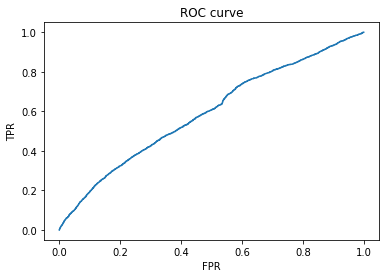

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


GaussianNB: 0.557582 (0.008910)
BernoulliNB: 0.556383 (0.007459)


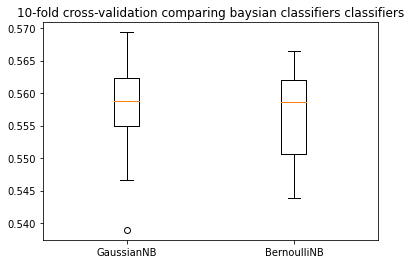

In [0]:
# Naive Baysian
# Did not use Multinomial NB due to negative values
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB

model_NB = GaussianNB()
NB = model_NB.fit(X_train, y_train)


#model evaluation
labels = np.unique(y_test)
cm = confusion_matrix(y_test,NB.predict(X_test), labels=labels)
print('Confusion Matrix:\n', pd.DataFrame(cm, index=labels, columns=labels))
print('\n')
print('Accuracy Score on the test data:', accuracy_score(y_true=y_test, y_pred=NB.predict(X_test)))
print('Accuracy Score on the train data:', accuracy_score(y_true=y_train, y_pred=NB.predict(X_train)))
print('\n')
print('Classification report:\n',classification_report(y_test,NB.predict(X_test)))

## roc curve
predictions = NB.predict_proba(X_test)
print("Area Under ROC Curve :" , roc_auc_score(y_test, predictions[:,1]))
fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

models = []
models.append(('GaussianNB', GaussianNB()))
models.append(('BernoulliNB', BernoulliNB()))

results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('10-fold cross-validation comparing baysian classifiers classifiers')
pyplot.show()

Confusion Matrix:
       0     1
0  3149  2645
1  2559  3329


Accuracy Score on the test data: 0.5545283341893511
Accuracy Score on the train data: 0.5563830394338869


Classification report:
               precision    recall  f1-score   support

           0       0.55      0.54      0.55      5794
           1       0.56      0.57      0.56      5888

    accuracy                           0.55     11682
   macro avg       0.55      0.55      0.55     11682
weighted avg       0.55      0.55      0.55     11682

Area Under ROC Curve : 0.5880933066768846


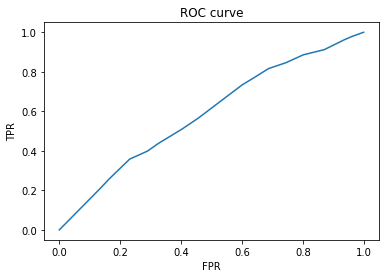

In [0]:
## support vector machine
from sklearn import svm

model_SVM = svm.SVC(gamma='0.001')
SVM = model.fit(X_train, y_train)

#model evaluation
labels = np.unique(y_test)
cm = confusion_matrix(y_test,SVM.predict(X_test), labels=labels)
print('Confusion Matrix:\n', pd.DataFrame(cm, index=labels, columns=labels))
print('\n')
print('Accuracy Score on the test data:', accuracy_score(y_true=y_test, y_pred=SVM.predict(X_test)))
print('Accuracy Score on the train data:', accuracy_score(y_true=y_train, y_pred=SVM.predict(X_train)))
print('\n')
print('Classification report:\n',classification_report(y_test,SVM.predict(X_test)))

## roc curve
predictions = SVM.predict_proba(X_test)
print("Area Under ROC Curve :" , roc_auc_score(y_test, predictions[:,1]))
fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()


In [0]:
## SVM hyper parameter tunning
# this may take a very long time and has been commented out 
'''
from sklearn.model_selection import GridSearchCV
h_params = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(svm.SVC(),h_params,refit=True,verbose=2)
grid.fit(X_train,y_train)
'''

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  35.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.5s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  35.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  34.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  35.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  35.7s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  19.9s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  20.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  20.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 129.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.585944 (0.005126)


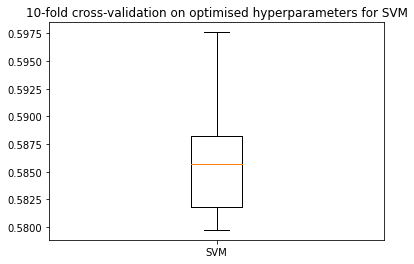

In [0]:
# SVM with optimised hyper parameters
## Commented as it may take a lot of time to run , results are included in report
'''
models = []
models.append(('SVM', svm.SVC(gamma='scale' , kernel='rbf' , C=1.0)))


results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('10-fold cross-validation on optimised hyperparameters for SVM')
pyplot.show()
'''

Confusion Matrix:
       0     1
0  3777  2017
1   783  5105


Accuracy Score on the test data: 0.7603150145523027
Accuracy Score on the train data: 0.8816983393254579


Classification report:
               precision    recall  f1-score   support

           0       0.83      0.65      0.73      5794
           1       0.72      0.87      0.78      5888

    accuracy                           0.76     11682
   macro avg       0.77      0.76      0.76     11682
weighted avg       0.77      0.76      0.76     11682

Area Under ROC Curve : 0.8305424065937776


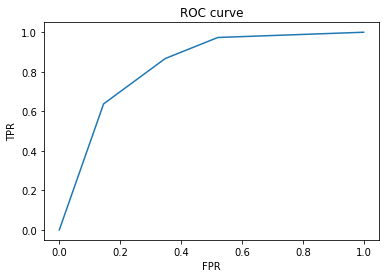

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Euclidean: 0.741796 (0.007748)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Manhattan: 0.741368 (0.007132)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Minkowski: 0.741796 (0.007748)


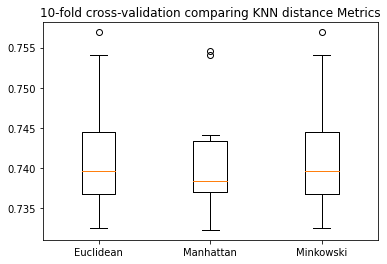

In [0]:
## k nearest neighbours
from sklearn.neighbors import KNeighborsClassifier
model_KNN = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
KNN = model_KNN.fit(X_train, y_train)

#model evaluation
labels = np.unique(y_test)
cm = confusion_matrix(y_test,KNN.predict(X_test), labels=labels)
print('Confusion Matrix:\n', pd.DataFrame(cm, index=labels, columns=labels))
print('\n')
print('Accuracy Score on the test data:', accuracy_score(y_true=y_test, y_pred=KNN.predict(X_test)))
print('Accuracy Score on the train data:', accuracy_score(y_true=y_train, y_pred=KNN.predict(X_train)))
print('\n')
print('Classification report:\n',classification_report(y_test,KNN.predict(X_test)))

## roc curve
predictions = KNN.predict_proba(X_test)
print("Area Under ROC Curve :" , roc_auc_score(y_test, predictions[:,1]))
fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

models = []
models.append(('Euclidean',  KNeighborsClassifier(n_neighbors=3, metric='euclidean')))
models.append(('Manhattan',  KNeighborsClassifier(n_neighbors=3, metric='manhattan')))
models.append(('Minkowski',  KNeighborsClassifier(n_neighbors=3, metric='minkowski')))

results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('10-fold cross-validation comparing KNN distance Metrics')
pyplot.show()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


LR saga solver: 0.560464 (0.007275)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


LR lbfgs solver: 0.560464 (0.007275)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


LR newton-cg solver: 0.560464 (0.007275)


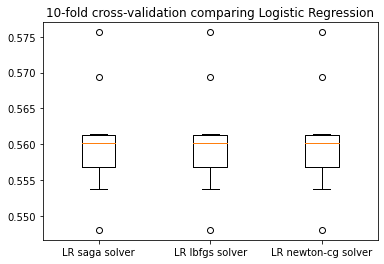

In [0]:
## logistic regression
from sklearn import linear_model
models = []
models.append(('LR saga solver', linear_model.LogisticRegression(solver='saga')))
models.append(('LR lbfgs solver', linear_model.LogisticRegression(solver='lbfgs')))
models.append(('LR newton-cg solver', linear_model.LogisticRegression(solver='newton-cg')))

results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('10-fold cross-validation comparing Logistic Regression')
pyplot.show()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN: 0.741796 (0.007748)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.585944 (0.005126)
GaussianNB: 0.557582 (0.008910)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packag

MLP: 0.604919 (0.005280)
Decision Tree: 0.834702 (0.008150)


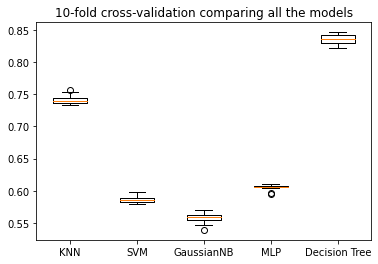

In [0]:
#final comparision between all the models
#this may take some time to run 
models = []
models.append(('KNN',  KNeighborsClassifier(n_neighbors=3, metric='euclidean')))
models.append(('SVM', svm.SVC(gamma='scale' , kernel='rbf' , C=1.0)))
models.append(('GaussianNB', GaussianNB()))
models.append(('MLP', MLPClassifier(random_state=0, activation='tanh', hidden_layer_sizes=(5,), solver='lbfgs', max_iter=100)))
models.append(('Decision Tree', DecisionTreeClassifier(random_state=0)))
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('10-fold cross-validation comparing all the models')
pyplot.show()


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

#names = [ "Random Forest", "Neural Net","Nearest Neighbors", "Linear SVM","RBF SVM","Gaussian Process","Decision Tree", "AdaBoost"]
names = ["Random Forest", "Neural Net","Nearest Neighbors"]


classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


In [12]:
y = y.reset_index()
del y['index']
y = y.to_numpy()
X = X.reset_index()
del X['index']
print(X.head())
print(X.columns)
#X = (X.loc[:,['principal component 1']]).to_numpy()
X = (X.loc[:,['principal component 1','principal component 2']]).to_numpy()

   principal component 1  ...  principal component 4
0              -0.137594  ...              -0.072651
1               0.490499  ...              -0.004051
2               0.127966  ...               0.170243
3               0.483700  ...               0.040399
4               0.532149  ...               0.003158

[5 rows x 4 columns]
Index(['principal component 1', 'principal component 2',
       'principal component 3', 'principal component 4'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


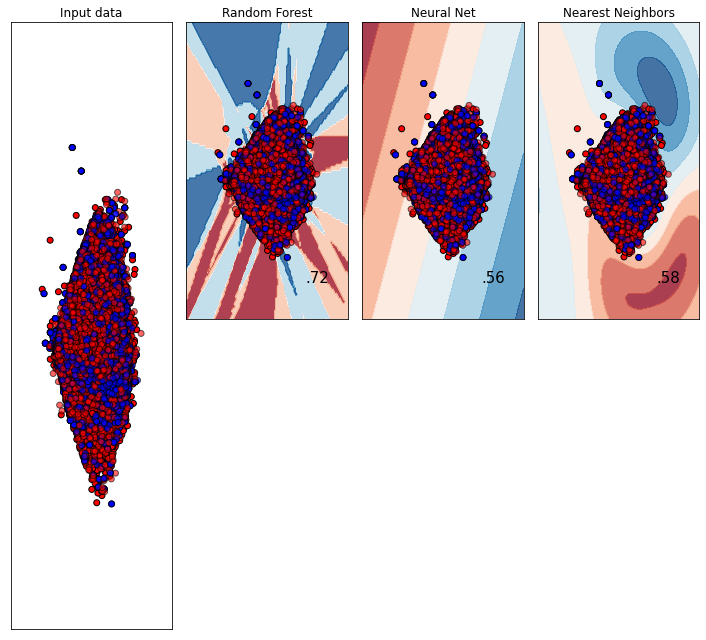

In [13]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

h = .02
i = 1
ds_cnt = 0
figure = plt.figure(figsize=(27, 9))
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, len(classifiers) + 1, i)
if ds_cnt == 0:
    ax.set_title("Input data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
            edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
            edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(2, len(classifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    if ds_cnt == 0:
        ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i += 1

plt.tight_layout()
plt.show()